In [1]:
from torchvision import datasets
train_dataset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./CIFAR10', train=False, download=True)
print(f"# of images (train): {len(train_dataset)}")
print(f"# of images (test): {len(test_dataset)}")
print(f"# of classes: {len(train_dataset.classes)}")
print(f"size of 1st image: {train_dataset[0][0].size}")

100%|██████████| 170M/170M [00:04<00:00, 41.1MB/s]


# of images (train): 50000
# of images (test): 10000
# of classes: 10
size of 1st image: (32, 32)


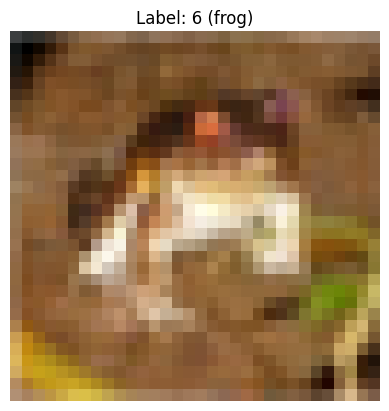

In [2]:
import matplotlib.pyplot as plt
image, label = train_dataset[0]
plt.imshow(image)
plt.title(f'Label: {label} ({train_dataset.classes[label]})')
plt.axis('off')
plt.show()

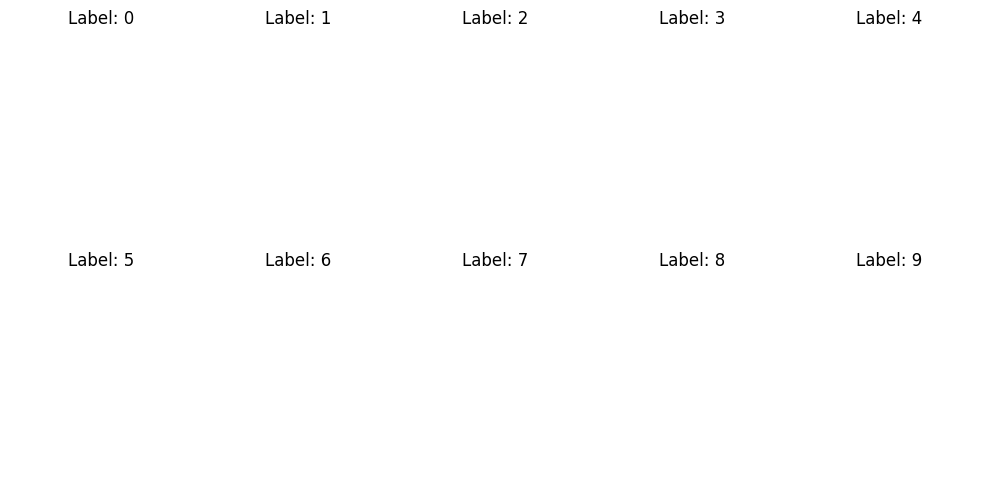

In [9]:
classes = train_dataset.classes
fig, axis = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    for image, label in train_dataset:
        if label == i:
            ax = axis[i // 5, i % 5]
            ax.set_title(f"Label: {int(label)}")
            ax.axis('off')
            break
plt.tight_layout()
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3 * 32 * 32, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten NCHW
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [11]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.classifier = nn.Linear(in_features=4*4*128, out_features=num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [15]:
model = CNN()

In [16]:
from torchvision.transforms.functional import to_tensor
image, label = train_dataset[0]
sample = to_tensor(image).unsqueeze(0)
sample = (sample - 0.5) / 0.5

In [17]:
logits = model(sample)
probs = F.softmax(logits, dim=1)

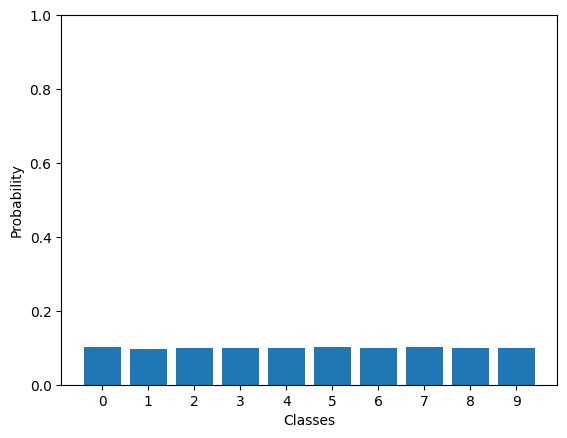

In [18]:
probs_np = probs.detach().numpy().flatten()
plt.bar(range(10), probs_np)
plt.ylabel('Probability')
plt.xticks(range(10))
plt.xlabel('Classes')
plt.ylim(0, 1)
plt.show()

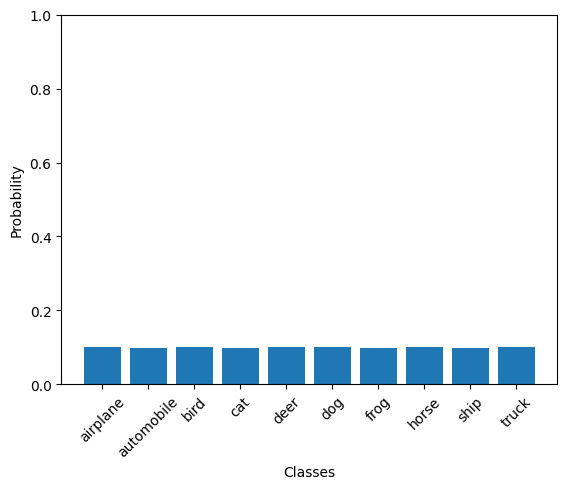

In [19]:
probs_np = probs.detach().numpy().flatten()
plt.bar(range(10), probs_np)
plt.ylabel('Probability')
plt.xticks(range(10), classes) # 変更
plt.xticks(rotation=45) # 変更
plt.xlabel('Classes')
plt.ylim(0, 1)
plt.show()

In [20]:
predicted_class = torch.argmax(probs, dim=1).item()
predicted_name = classes[predicted_class]
print(f"Predicted class: {predicted_class} ({predicted_name})")

Predicted class: 0 (airplane)


In [21]:
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
batch_size = 64
num_epochs = 5
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.CIFAR10(root='./CIFAR10', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [23]:
import torch.optim as optim

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
epoch_loss = total_loss / len(train_dataset)
print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 5/5: 100%|██████████| 782/782 [04:35<00:00,  2.84it/s]

Epoch 5, Loss: 0.4140


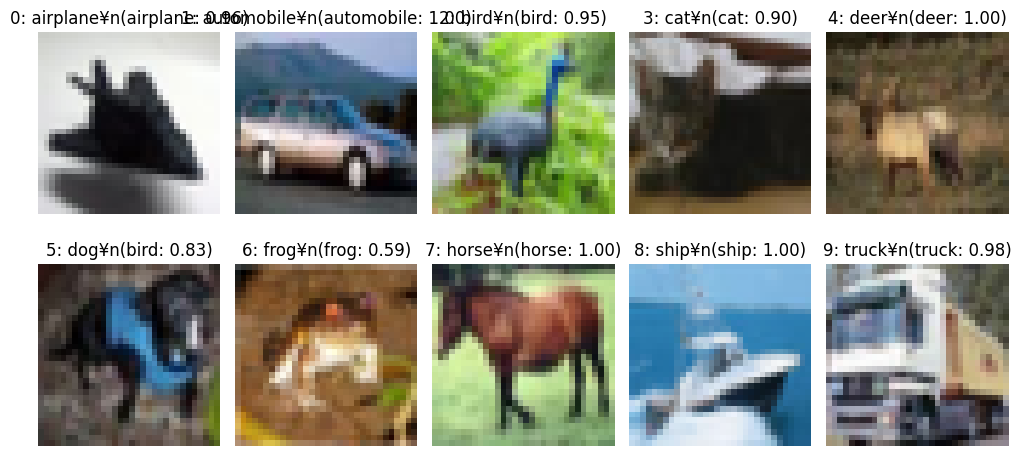

In [24]:
train_dataset = datasets.CIFAR10(root='./CIFAR10', train=True, download=True)
model.eval()
fig, axis = plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
    for image, label in train_dataset:
        if label == i:
          logits = model(transform(image).unsqueeze(0))
          probs = F.softmax(logits, dim=1)
          predicted_label = torch.argmax(probs, dim=1).item()
          ax = axis[i // 5, i % 5]
          ax.imshow(image)
          ax.set_title(f'{label}: {classes[label]}¥n({classes[predicted_label]}: {probs[0][predicted_label]:.2f})')
          ax.axis('off')
          break
plt.tight_layout()
plt.show()

In [25]:
test_dataset = datasets.CIFAR10(root='./CIFAR10', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Accuracy on test set: 74.69%


In [26]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.linear1 = nn.Linear(64 * 8 * 8, 512)
        self.linear2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [27]:
import torch.optim as optim
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
epoch_loss = total_loss / len(train_dataset)
print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 5/5: 100%|██████████| 782/782 [01:30<00:00,  8.63it/s]

Epoch 5, Loss: 0.3816
